In [2]:
import os
os.chdir("..")


In [3]:
%load_ext autoreload 

In [4]:
%autoreload 2
from src.transforms.motion_transform import MotionTsfd
from src.transforms.base_transform import Preprocess,Augment
from src.dataset.hcp_dataset import HCP
import matplotlib.pyplot as plt
import torchio as tio

c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ds = HCP.lab(Preprocess())

Loading dataset:   0%|          | 0/1113 [00:00<?, ?it/s]


RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x000002F3FCAEFF10>

(metatensor(0.9776), metatensor(0.))

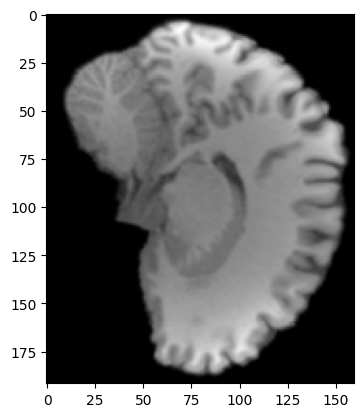

In [8]:
vol = ds[0]["data"]
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()

In [61]:
motion =MotionTsfd()

Loading dataset: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


2


(tensor(1.0401), tensor(0.))

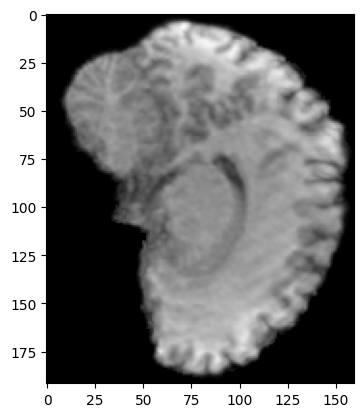

In [75]:
vol = motion(ds[0])["data"]
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()

(metatensor(0.9666), metatensor(0.))

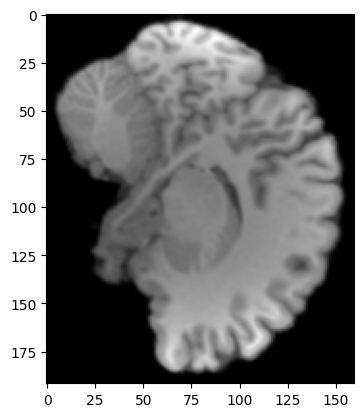

In [110]:
aug=Augment()
vol = aug(ds[0])["data"]
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()

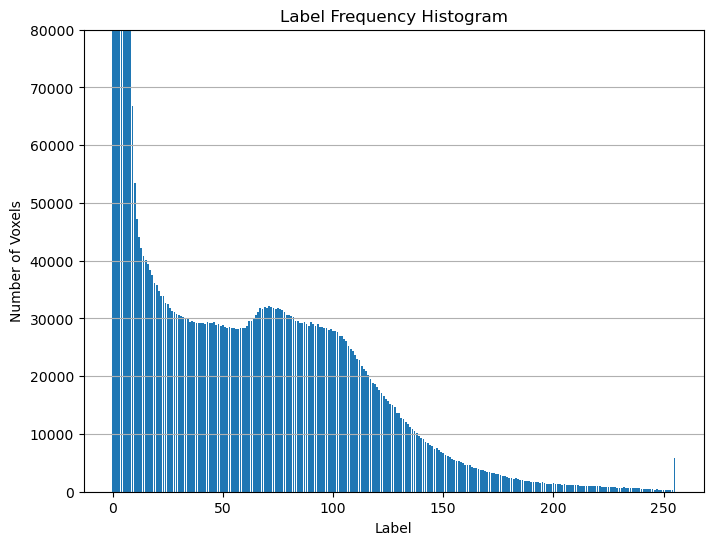

In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

input_label_path = 'C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig.mgz'



idx = input_label_path
def get_hist(path):
    img = nib.load(path)
    data = img.get_fdata()
    # Initialize a dictionary to store label frequencies
    label_counts = {}
    # Count the voxels for each label
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                label = data[i, j, k]
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1

    # Create the histogram
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Number of Voxels')
    plt.title('Label Frequency Histogram')
    plt.grid(axis='y')

    plt.ylim(top=80000)

get_hist('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig.mgz')


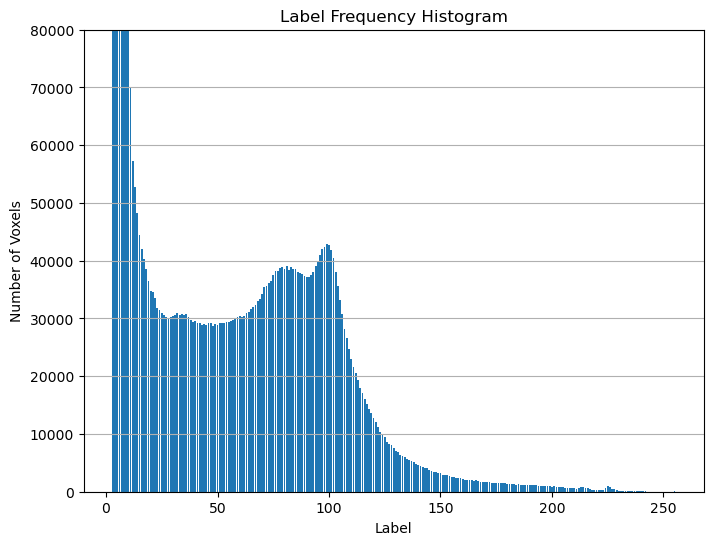

In [18]:
get_hist('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig_nu.nii.gz')


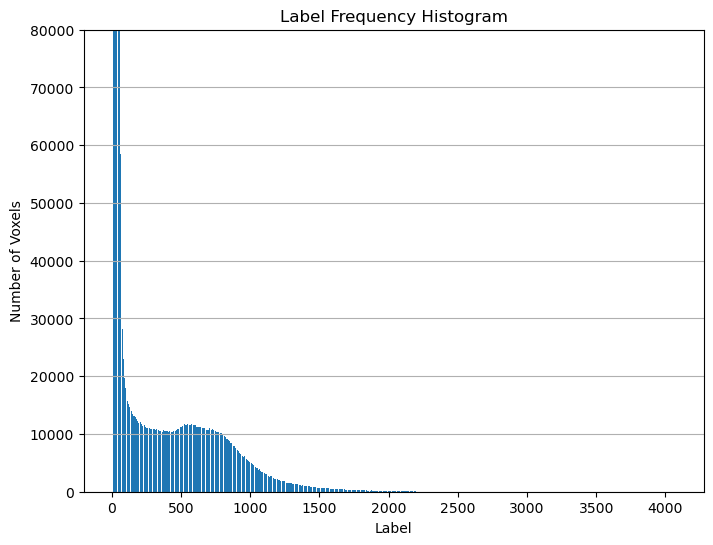

In [19]:
get_hist('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig/001.mgz')


In [2]:
from torchio.transforms.preprocessing import ZNormalization
from monai.transforms.io.array import LoadImage

c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


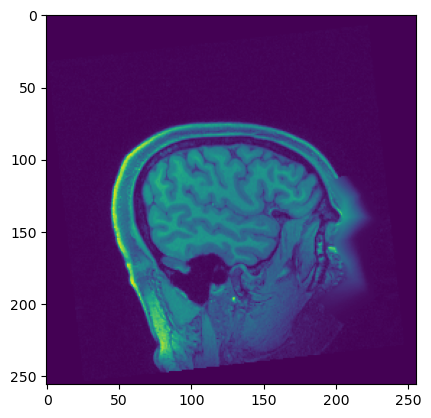

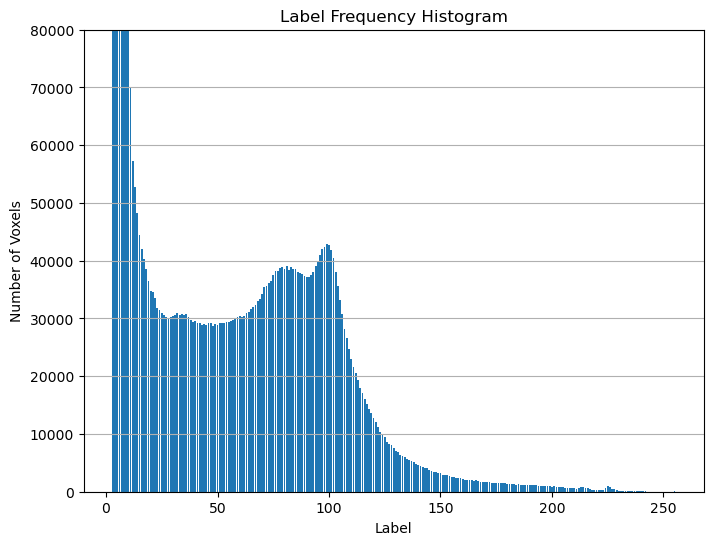

In [9]:
img = LoadImage(image_only=True, ensure_channel_first=True)('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig_nu.nii.gz')
plt.imshow(img[0,80,:,:])
def get_hist_vol(vol):
    data = vol.numpy()
    # Initialize a dictionary to store label frequencies
    label_counts = {}
    # Count the voxels for each label
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                label = data[i, j, k]
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1

    # Create the histogram
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Number of Voxels')
    plt.title('Label Frequency Histogram')
    plt.grid(axis='y')

    plt.ylim(top=80000)
get_hist_vol(img[0])

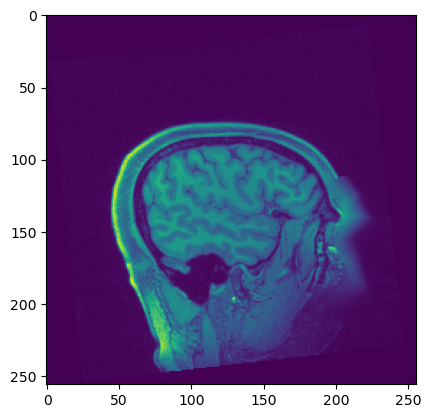

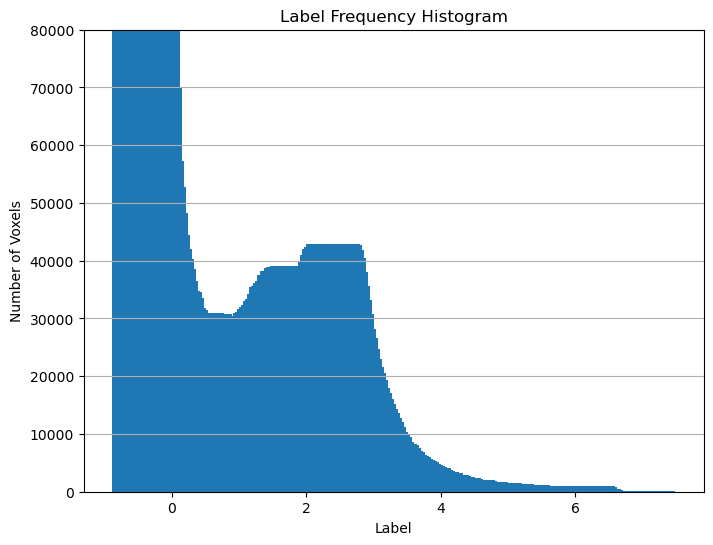

In [11]:
norm = ZNormalization()
norm_im = norm(norm_im)
plt.imshow(norm_im[0,80,:,:])
get_hist_vol(norm_im[0])